In [1]:
import os
import keras
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import optimizers
from keras.layers import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, Callback

%tensorflow_version 2.x
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
x_train, x_test, x_val = x_train / 255.0, x_test / 255.0, x_val / 255.0

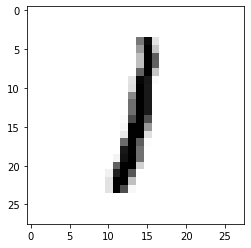

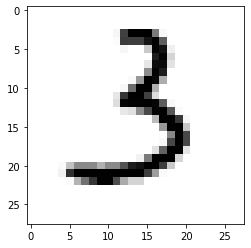

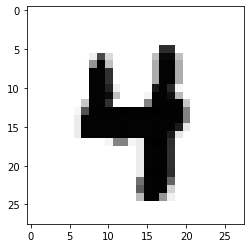

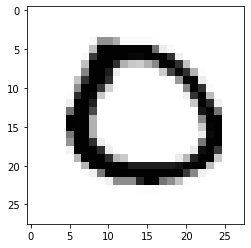

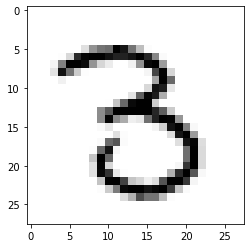

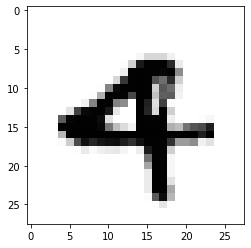

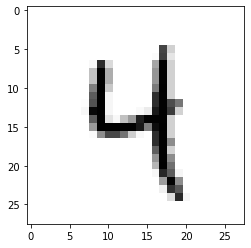

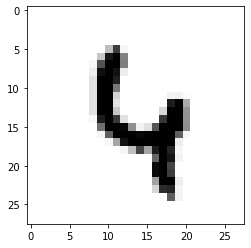

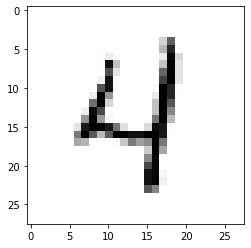

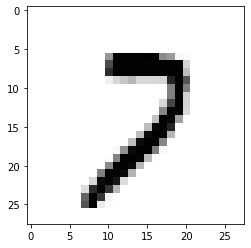

In [4]:

# Before preprocessing the dataset with LeNet-5 network, checking the data
for i in range(10):
    img = np.asfarray(x_train)[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

In [0]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [0]:
x_train = x_train.reshape(len(x_train),28*28).reshape(len(x_train),28,28,1)
x_val = x_val.reshape(len(x_val),28*28).reshape(len(x_val),28,28,1)
x_test = x_test.reshape(len(x_test),28*28).reshape(len(x_test),28,28,1)

In [0]:
x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_val = np.pad(x_val, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test = np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

In [0]:

EPOCHS = 10
BATCH_SIZE = 128
image_size  = 32
input_shape = (image_size, image_size, 1)

In [0]:
# This is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator()

In [0]:
train_generator = train_datagen.flow(
                x_train,
                y_train,
                shuffle = True,
                batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(
                x_val,
                y_val,
                shuffle = True,
                batch_size=BATCH_SIZE)

In [0]:
# Setting checkpoint & early stopping
#df_train = pd.read_csv('/content/drive/My Drive/CMPE 258/Assignment 3/train_v2.csv')
checkpoint_path = os.path.join('/content/drive/My Drive/CMPE 258/Assignment 4/','model_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5')
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_list = [checkpoint, tensorboard_callback]

In [0]:
model = keras.models.Sequential()
model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(AveragePooling2D())
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=10, activation = 'softmax'))

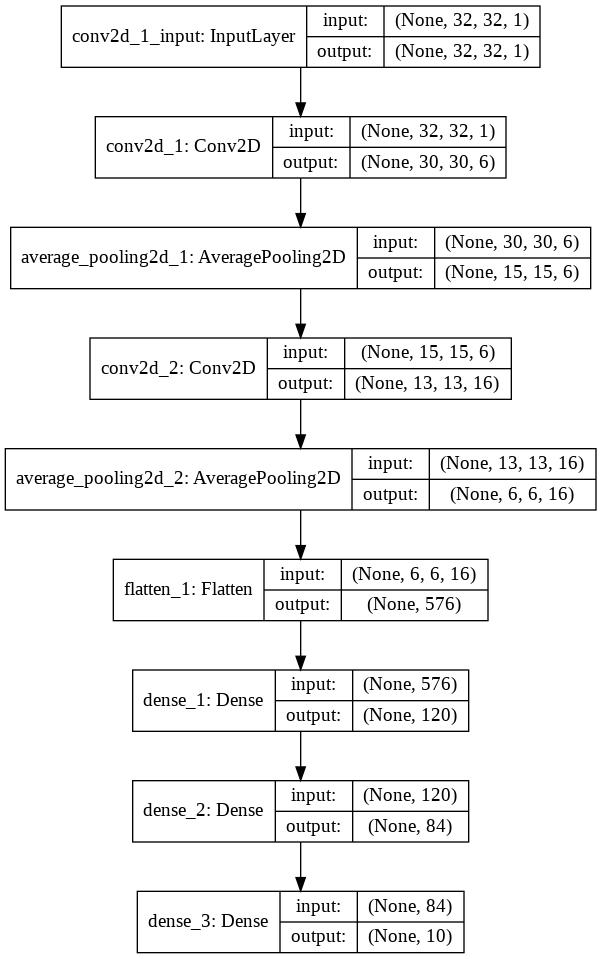

In [13]:
keras.utils.plot_model(model, "lenet5.png", show_shapes=True)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit_generator(train_generator,
                                steps_per_epoch=len(train_generator),
                                validation_data=val_generator,
                                validation_steps=len(val_generator),
                                callbacks=callbacks_list,
                                shuffle=True,                                 
                                epochs=EPOCHS)

Epoch 1/10
375/375 [==============================] - 32s 85ms/step - loss: 0.6386 - accuracy: 0.8010 - val_loss: 0.5456 - val_accuracy: 0.9052

Epoch 00001: val_accuracy improved from -inf to 0.90517, saving model to /content/drive/My Drive/CMPE 258/Assignment 4/model_best_weights.01-0.9052.hdf5
Epoch 2/10
375/375 [==============================] - 32s 84ms/step - loss: 0.2496 - accuracy: 0.9238 - val_loss: 0.1592 - val_accuracy: 0.9355

Epoch 00002: val_accuracy improved from 0.90517 to 0.93550, saving model to /content/drive/My Drive/CMPE 258/Assignment 4/model_best_weights.02-0.9355.hdf5
Epoch 3/10
375/375 [==============================] - 31s 83ms/step - loss: 0.1828 - accuracy: 0.9458 - val_loss: 0.0655 - val_accuracy: 0.9466

Epoch 00003: val_accuracy improved from 0.93550 to 0.94658, saving model to /content/drive/My Drive/CMPE 258/Assignment 4/model_best_weights.03-0.9466.hdf5
Epoch 4/10
375/375 [==============================] - 31s 84ms/step - loss: 0.1520 - accuracy: 0.952

In [18]:
score = model.evaluate(x_test,y_test)
print("Test Loss: ",score[0])
print("Test Accuracy: ",score[1])

10000/10000 [==============================] - 2s 249us/step
Test Loss:  0.07074482229766436
Test Accuracy:  0.9776999950408936


In [0]:
y_pred = model.predict_classes(x_test)
y_pred = to_categorical(y_pred)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.93      0.99      0.96      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.95      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.99      0.98      1028
           8       1.00      0.94      0.97       974
           9       0.98      0.98      0.98      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000
 samples avg       0.98      0.98      0.98     10000

